# `CLOUD.jl` - 2D linear advection with dynamic mode decomposition

In [1]:
using CLOUD
using Plots
using OrdinaryDiffEq
plots_path = "../plots/advection1d_demo/"
results_path = "../results/advection1d_demo/";

Define the physical problem

In [2]:
a = (1.0,1.0)  # advection velocity
A = 1.0  # amplitude
L = 1.0  # domain length
k = 2*π/L  # wave number
T = sqrt(2)*L/a  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation(a,λ=1.0)
u_exact = initial_condition(initial_data, conservation_law);

MethodError: MethodError: no method matching /(::Float64, ::Tuple{Float64, Float64})
Closest candidates are:
  /(::Any, !Matched::ChainRulesCore.AbstractThunk) at /Users/tristanmontoya/.julia/packages/ChainRulesCore/bxKCw/src/tangent_types/thunks.jl:33
  /(::Union{Float16, Float32, Float64}, !Matched::BigFloat) at mpfr.jl:443
  /(::Union{Bool, Float16, Float32, Float64, Int16, Int32, Int64, Int8, UInt16, UInt32, UInt64, UInt8, SIMDTypes.Bit}, !Matched::VectorizationBase.VecUnroll{N, W, T, V} where {T, V<:Union{Bool, Float16, Float32, Float64, Int16, Int32, Int64, Int8, UInt16, UInt32, UInt64, UInt8, SIMDTypes.Bit, VectorizationBase.AbstractSIMD{W, T}}}) where {N, W} at /Users/tristanmontoya/.julia/packages/VectorizationBase/xHOp9/src/base_defs.jl:91
  ...

Set up a strong-form DGSEM-LGL scheme of degree `p` with `M` elements

In [3]:
M = 8  # number of elements
p = 3  # degree of discretization
reference_approximation=ReferenceApproximation(
    DGSEM(p), Line(), LGLQuadrature())
spatial_discretization = SpatialDiscretization(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    (0.0,L), M), reference_approximation)
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, StrongConservationForm(), 
     (0.0, T), Eager(), results_path, overwrite=true, clear=true);

UndefVarError: UndefVarError: T not defined

Run the `OrdinaryDiffEq` solver with RK4, taking `n_s` snapshots

In [4]:
n_s = 10
dt = dt_scale*(L/M)/(a*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, RK4(), adaptive=false, 
    dt=dt, save_everystep=false,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final");

UndefVarError: UndefVarError: dt_scale not defined

Visualize the solution and calculate the integral L<sup>2</sup> error norm

In [5]:
plotter = Plotter(spatial_discretization, plots_path)
error_analysis = ErrorAnalysis(conservation_law, spatial_discretization, results_path)
print("L2 error: ", analyze(error_analysis, last(sol.u), u_exact)[1])
visualize(last(sol.u), plotter,
    "final.pdf", exact_solution=u_exact,
     label="U^h(x,t)", label_exact="U(x,t)")

UndefVarError: UndefVarError: conservation_law not defined

Run a dynamic mode decomposition (truncated to `n_m` modes via POD) on snapshot data

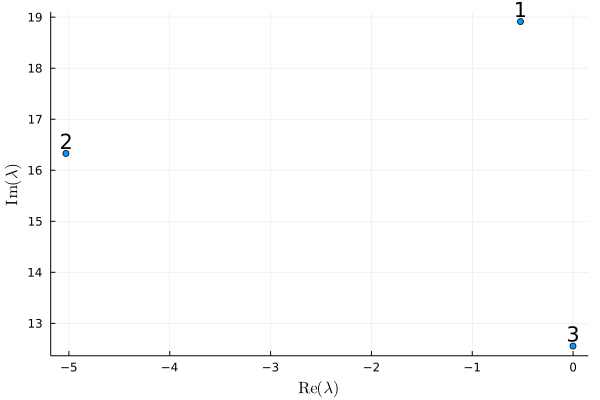

In [6]:
n_m = 3
dmd = DMDAnalysis(results_path,rank=2*n_m)
X, Y = load_snapshots(results_path, dmd.time_steps)
σ, λ, ϕ = analyze(dmd, X, Y)
plot_spectrum(dmd, λ[imag(λ) .> 0]) #only upper half of complex plane due to symmetry

Plot the first `n_m` DMD mode shapes

In [7]:
mode_plotter = Plotter(spatial_discretization, dmd.path)
plot_modes(dmd, mode_plotter, ϕ[:,imag(λ) .> 0], 1)

BoundsError: BoundsError: attempt to access 66-element Vector{Float64} at index [1:88]